# QAOA for portofolio optimization
In this tutorial, we will solve the portfolio optimization using the Quantum Approximate Optimization Algorithm (QAOA).

In [75]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import networkx as nx
import qiskit.primitives as qk_pr

import jijmodeling as jm
import ommx.v1
from ommx_pyscipopt_adapter import OMMXPySCIPOptAdapter

import qamomile.core as qm
from qamomile.qiskit import QiskitTranspiler
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.core.converters.fqaoa import FQAOAConverter

## Constructing the Mathematical Model

First, we will implement the mathematical model of the portofolio optimization problem using JijModeling.

In [76]:
def create_potofolio_optimzation_problem():
    N = jm.Placeholder("N")
    D = jm.Placeholder("D")
    M = jm.Placeholder("M")
    lam = jm.Placeholder("lam")
    lam.set_latex("\lambda")
    sigma = jm.Placeholder("sigma", ndim=2)
    sigma.set_latex("\sigma")
    mu = jm.Placeholder("mu", ndim=1)
    mu.set_latex("\mu")
    
    x = jm.BinaryVar("x", shape=(N,D))
    l = jm.Element("l", belong_to=(0,N))
    l_dash = jm.Element("l'", belong_to=(0,N))
    d = jm.Element("d", belong_to=(0,D))
    d_dash = jm.Element("d'", belong_to=(0,D))
    
    problem = jm.Problem("Portfolio Optimization", sense=jm.ProblemSense.MINIMIZE)
    
    problem += lam/(M**2) * jm.sum([l, l_dash], sigma[l,l_dash] * jm.sum([d, d_dash], (x[l,d] - 1/2) * (x[l_dash, d_dash] - 1/2))) + (1-lam)/M * jm.sum(l, mu[l] * jm.sum(d, (x[l,d] - 1/2)))
    
    problem += jm.Constraint("the total number of stock holdings", jm.sum([l,d], x[l,d])==(N*D/2-M))
    
    return problem
    
problem = create_potofolio_optimzation_problem()
problem

## Make an instance of the problem

In [77]:
num_integer = 8
num_bit = 2
num_stock = 4
lam = 0.9
sigma = np.array([
    [99.8,  42.5,  37.2,  40.3,  38.0,  30.0,  46.8,  14.9],
    [42.5, 100.5,  41.1,  15.2,  71.1,  27.8,  47.5,  12.7],
    [37.2,  41.1, 181.3,  17.9,  38.4,  27.9,  39.0,   8.3],
    [40.3,  15.2,  17.9, 253.1,  12.4,  48.7,  33.3,   3.8],
    [38.0,  71.1,  38.4,  12.4,  84.7,  28.5,  42.0,  13.1],
    [30.0,  27.8,  27.9,  48.7,  28.5, 173.1,  28.9, -12.7],
    [46.8,  47.5,  39.0,  33.3,  42.0,  28.9, 125.8,  14.6],
    [14.9,  12.7,   8.3,   3.8,  13.1, -12.7,  14.6, 179.0]
])
mu = np.array([401.0, 61.0, 916.0, -619.0, 212.0, 1477.0, 1047.0, -881.0])

instance_data = {"N": num_integer, "D": num_bit, "M": num_stock, "lam": lam, "sigma": sigma, "mu": mu}
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)

instance.objective

Function(5.61375*x0*x0 + 11.2275*x0*x1 + 4.78125*x0*x2 + 4.78125*x0*x3 + 4.1850000000000005*x0*x4 + 4.1850000000000005*x0*x5 + 4.5337499999999995*x0*x6 + 4.5337499999999995*x0*x7 + 4.275*x0*x8 + 4.275*x0*x9 + 3.375*x0*x10 + 3.375*x0*x11 + 5.265*x0*x12 + 5.265*x0*x13 + 1.67625*x0*x14 + 1.67625*x0*x15 + 5.61375*x1*x1 + 4.78125*x1*x2 + 4.78125*x1*x3 + 4.1850000000000005*x1*x4 + 4.1850000000000005*x1*x5 + 4.5337499999999995*x1*x6 + 4.5337499999999995*x1*x7 + 4.275*x1*x8 + 4.275*x1*x9 + 3.375*x1*x10 + 3.375*x1*x11 + 5.265*x1*x12 + 5.265*x1*x13 + 1.67625*x1*x14 + 1.67625*x1*x15 + 5.653125*x2*x2 + 11.30625*x2*x3 + 4.62375*x2*x4 + 4.62375*x2*x5 + 1.71*x2*x6 + 1.71*x2*x7 + 7.998749999999999*x2*x8 + 7.998749999999999*x2*x9 + 3.1275*x2*x10 + 3.1275*x2*x11 + 5.34375*x2*x12 + 5.34375*x2*x13 + 1.42875*x2*x14 + 1.42875*x2*x15 + 5.653125*x3*x3 + 4.62375*x3*x4 + 4.62375*x3*x5 + 1.71*x3*x6 + 1.71*x3*x7 + 7.998749999999999*x3*x8 + 7.998749999999999*x3*x9 + 3.1275*x3*x10 + 3.1275*x3*x11 + 5.34375*x3*x12 +

In [78]:
instance.decision_variables

,kind,lower,upper,name,subscripts,description,substituted_value
id,,,,,,,
0,binary,0.0,1.0,x,"[0, 0]",<NA>,<NA>
1,binary,0.0,1.0,x,"[0, 1]",<NA>,<NA>
2,binary,0.0,1.0,x,"[1, 0]",<NA>,<NA>
3,binary,0.0,1.0,x,"[1, 1]",<NA>,<NA>
4,binary,0.0,1.0,x,"[2, 0]",<NA>,<NA>
5,binary,0.0,1.0,x,"[2, 1]",<NA>,<NA>
6,binary,0.0,1.0,x,"[3, 0]",<NA>,<NA>
7,binary,0.0,1.0,x,"[3, 1]",<NA>,<NA>
8,binary,0.0,1.0,x,"[4, 0]",<NA>,<NA>


In [79]:
constraint = instance.get_constraints()
print(constraint[0].function)

instance.constraints

Function(x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14 + x15 - 4)


,equality,type,used_ids,name,subscripts,description
id,,,,,,
0,=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",the total number of stock holdings,[],<NA>


## Calculate the exact solution for a classical solver

In [80]:
# PySCIPOptのModelを介してommx.v1.Solutionを取得する
solution = OMMXPySCIPOptAdapter.solve(instance)
exact_val = solution.objective
solution.decision_variables

,kind,lower,upper,name,subscripts,description,substituted_value,value
id,,,,,,,,
0,binary,0.0,1.0,x,"[0, 0]",<NA>,<NA>,-1.370015e-13
1,binary,0.0,1.0,x,"[0, 1]",<NA>,<NA>,0.000000e+00
2,binary,0.0,1.0,x,"[1, 0]",<NA>,<NA>,1.000000e+00
3,binary,0.0,1.0,x,"[1, 1]",<NA>,<NA>,1.000000e+00
4,binary,0.0,1.0,x,"[2, 0]",<NA>,<NA>,0.000000e+00
5,binary,0.0,1.0,x,"[2, 1]",<NA>,<NA>,0.000000e+00
6,binary,0.0,1.0,x,"[3, 0]",<NA>,<NA>,1.000000e+00
7,binary,0.0,1.0,x,"[3, 1]",<NA>,<NA>,0.000000e+00
8,binary,0.0,1.0,x,"[4, 0]",<NA>,<NA>,-1.371125e-13


## Implementing QAOA using Qamomile

In [ ]:
def pauli_matrix(id):
	if id == 0:
		return np.array([[1.,0.],[0.,1.]])
	elif id == 1:
		return np.array([[1.,0.],[0.,1.]])

def get_ising_matrix(ising):
	

In [81]:
fqaoa_converter = FQAOAConverter(instance, num_fermions=4, mixer_connectivity='cyclic', normalize_model=False)

p = 4
fqaoa_circuit = fqaoa_converter.get_fqaoa_ansatz(p)
fqaoa_cost = fqaoa_converter.get_cost_hamiltonian()
fqaoa_cost

Hamiltonian((Z0,): -5.012500000000003, (Z1,): -5.012500000000003, (Z2,): -0.762499999999998, (Z3,): -0.762499999999998, (Z4,): -11.450000000000006, (Z5,): -11.450000000000006, (Z6,): 7.737499999999996, (Z7,): 7.737499999999996, (Z8,): -2.6499999999999977, (Z9,): -2.6499999999999986, (Z10,): -18.4625, (Z11,): -18.4625, (Z12,): -13.087499999999995, (Z13,): -13.087499999999995, (Z14,): 11.0125, (Z15,): 11.0125, (Z0, Z1): 2.806875, (Z0, Z2): 1.1953125, (Z0, Z3): 1.1953125, (Z0, Z4): 1.0462500000000001, (Z0, Z5): 1.0462500000000001, (Z0, Z6): 1.1334374999999999, (Z0, Z7): 1.1334374999999999, (Z0, Z8): 1.06875, (Z0, Z9): 1.06875, (Z0, Z10): 0.84375, (Z0, Z11): 0.84375, (Z0, Z12): 1.31625, (Z0, Z13): 1.31625, (Z0, Z14): 0.4190625, (Z0, Z15): 0.4190625, (Z1, Z2): 1.1953125, (Z1, Z3): 1.1953125, (Z1, Z4): 1.0462500000000001, (Z1, Z5): 1.0462500000000001, (Z1, Z6): 1.1334374999999999, (Z1, Z7): 1.1334374999999999, (Z1, Z8): 1.06875, (Z1, Z9): 1.06875, (Z1, Z10): 0.84375, (Z1, Z11): 0.84375, (Z1,

In [82]:
def number_to_spinstring(number: int, num_spins: int):
    bitstring = np.flipud(np.array(list(np.binary_repr(number, width=num_spins)), dtype=int))
    spinstring = 1 - 2 * bitstring
    
    return spinstring.tolist()

num_qubits = int(num_integer * num_bit)

ising_instance = fqaoa_converter.get_ising()
print(ising_instance)

max_energy = -1e5
min_energy = 1e5
for i in range(2**num_qubits):
	spin_list = number_to_spinstring(i, num_qubits)
	energy = ising_instance.calc_energy(spin_list)
 
	if energy > max_energy:
		max_energy = energy
	if energy < min_energy:
		min_energy = energy
  
energy_range = np.abs(max_energy - min_energy)

min_energy -= ising_instance.constant
max_energy -= ising_instance.constant

print(f"max energy: {max_energy}, min energy: {min_energy}")

IsingModel(quad={(0, 1): 2.806875, (0, 2): 1.1953125, (0, 3): 1.1953125, (0, 4): 1.0462500000000001, (0, 5): 1.0462500000000001, (0, 6): 1.1334374999999999, (0, 7): 1.1334374999999999, (0, 8): 1.06875, (0, 9): 1.06875, (0, 10): 0.84375, (0, 11): 0.84375, (0, 12): 1.31625, (0, 13): 1.31625, (0, 14): 0.4190625, (0, 15): 0.4190625, (1, 2): 1.1953125, (1, 3): 1.1953125, (1, 4): 1.0462500000000001, (1, 5): 1.0462500000000001, (1, 6): 1.1334374999999999, (1, 7): 1.1334374999999999, (1, 8): 1.06875, (1, 9): 1.06875, (1, 10): 0.84375, (1, 11): 0.84375, (1, 12): 1.31625, (1, 13): 1.31625, (1, 14): 0.4190625, (1, 15): 0.4190625, (2, 3): 2.8265625, (2, 4): 1.1559375, (2, 5): 1.1559375, (2, 6): 0.4275, (2, 7): 0.4275, (2, 8): 1.9996874999999998, (2, 9): 1.9996874999999998, (2, 10): 0.781875, (2, 11): 0.781875, (2, 12): 1.3359375, (2, 13): 1.3359375, (2, 14): 0.3571875, (2, 15): 0.3571875, (3, 4): 1.1559375, (3, 5): 1.1559375, (3, 6): 0.4275, (3, 7): 0.4275, (3, 8): 1.9996874999999998, (3, 9): 1.99

In [83]:
instance.constraints

,equality,type,used_ids,name,subscripts,description
id,,,,,,
0,=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",the total number of stock holdings,[],<NA>


## Test FQAOA circuit

### p=0 (only initial state circuit)

In [84]:
init_circuit = fqaoa_converter.get_init_state()

qk_transpiler = QiskitTranspiler()
qk_test_01_circuit = qk_transpiler.transpile_circuit(init_circuit)

sampler = qk_pr.StatevectorSampler()
qk_test_01_circuit.measure_all()
job = sampler.run([(qk_test_01_circuit)], shots=10000)
job_result = job.result()[0]

test_01_sampleset = fqaoa_converter.decode(qk_transpiler, job_result.data["meas"])
df_test_01_sampleset = test_01_sampleset.summary
print("feasible solutions: ",(df_test_01_sampleset['feasible'] == True).sum())
print("infeasible solutions: ",(df_test_01_sampleset['feasible'] == False).sum())


feasible solutions:  10000
infeasible solutions:  0


### add cost

In [85]:
rng = np.random.default_rng()
cost_circuit = fqaoa_converter.get_init_state()
cost_circuit.append(fqaoa_converter.get_cost_ansatz(gamma=rng.uniform(0.0, 1.0)))

qk_transpiler = QiskitTranspiler()
qk_test_02_circuit = qk_transpiler.transpile_circuit(cost_circuit)

sampler = qk_pr.StatevectorSampler()
qk_test_02_circuit.measure_all()
job2 = sampler.run([(qk_test_02_circuit)], shots=10000)
job2_result = job2.result()[0]

test_02_sampleset = fqaoa_converter.decode(qk_transpiler, job2_result.data["meas"])
df_test_02_sampleset = test_02_sampleset.summary
print("feasible solutions: ",(df_test_02_sampleset['feasible'] == True).sum())
print("infeasible solutions: ",(df_test_02_sampleset['feasible'] == False).sum())

feasible solutions:  10000
infeasible solutions:  0


### add cost and mixer (p=1)

feasible solutions:  10000
infeasible solutions:  0


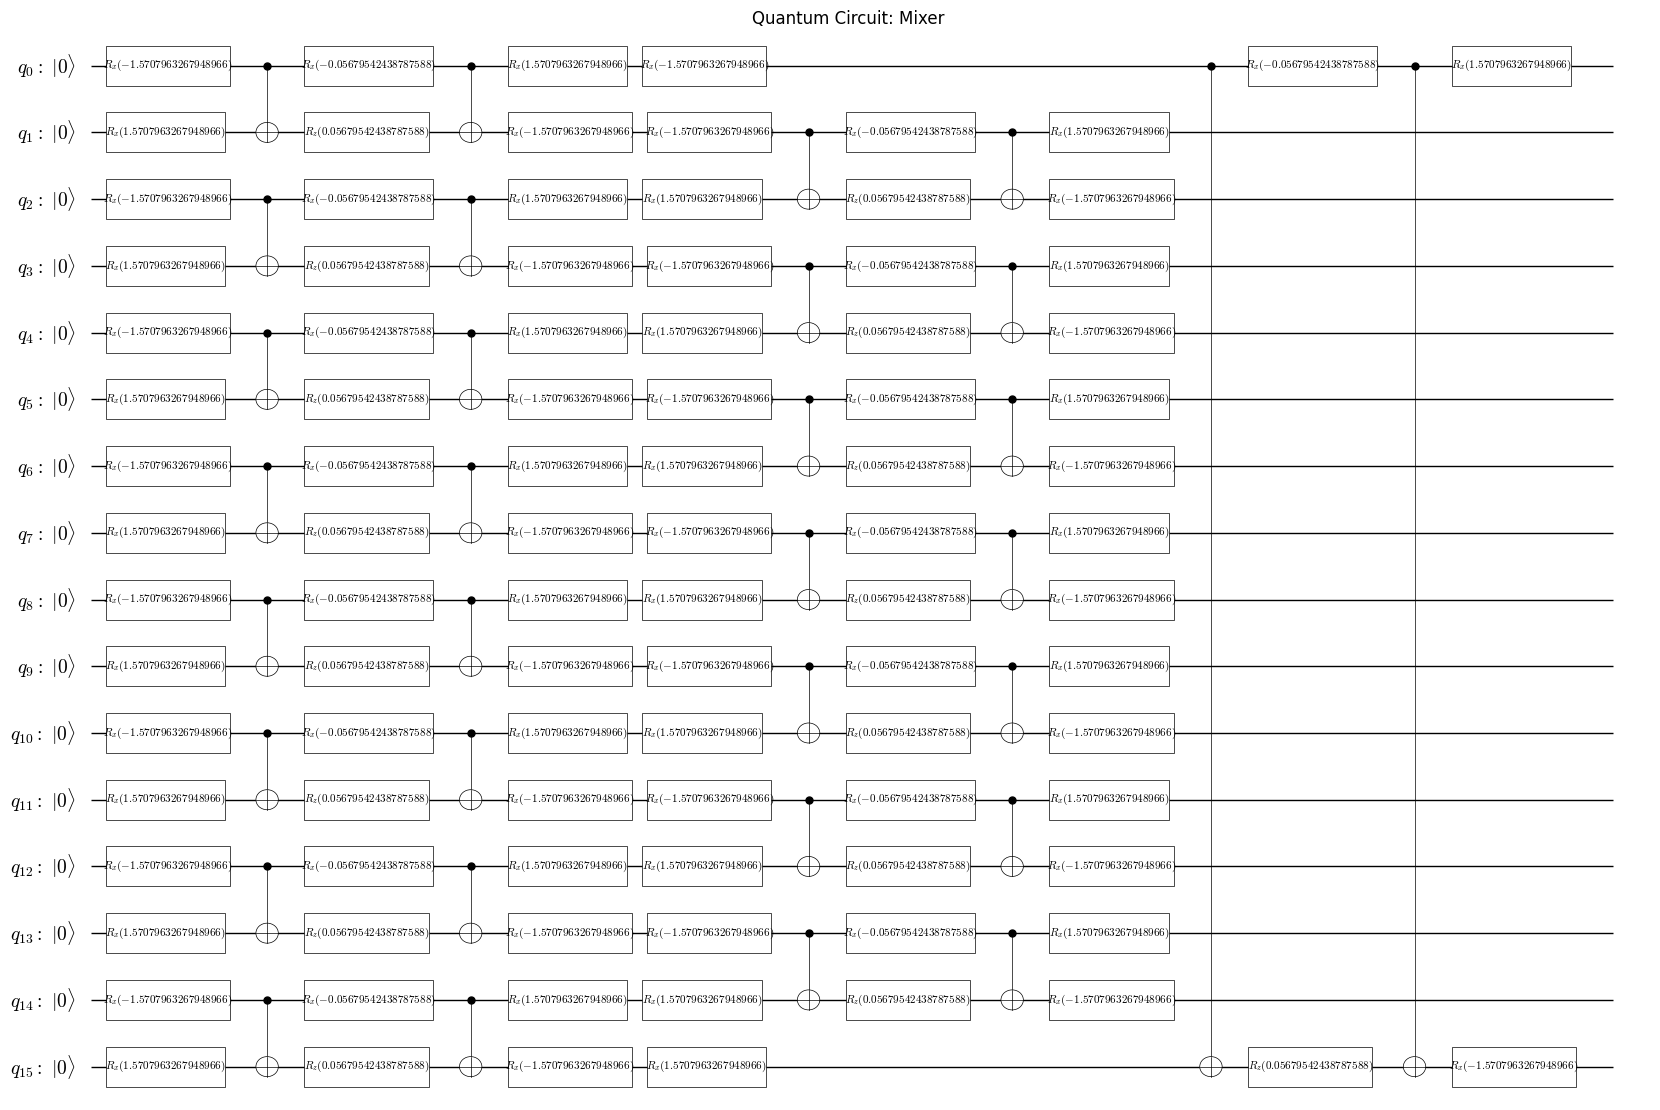

None


In [86]:
rng = np.random.default_rng()
p1_circuit = fqaoa_converter.get_init_state()
p1_circuit.append(fqaoa_converter.get_cost_ansatz(gamma=rng.uniform(0.0, 1.0)))
mixer = fqaoa_converter.get_mixer_ansatz(beta=rng.uniform(0.0, 1.0))
p1_circuit.append(mixer)

qk_transpiler = QiskitTranspiler()
qk_test_03_circuit = qk_transpiler.transpile_circuit(p1_circuit)

sampler = qk_pr.StatevectorSampler()
qk_test_03_circuit.measure_all()
job3 = sampler.run([(qk_test_03_circuit)], shots=10000)
job3_result = job3.result()[0]

test_03_sampleset = fqaoa_converter.decode(qk_transpiler, job3_result.data["meas"])
df_test_03_sampleset = test_03_sampleset.summary
print("feasible solutions: ",(df_test_03_sampleset['feasible'] == True).sum())
print("infeasible solutions: ",(df_test_03_sampleset['feasible'] == False).sum())

print(plot_quantum_circuit(mixer))

## Run QAOA using Qiskit

In [87]:
qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(fqaoa_circuit)
qk_cost = qk_transpiler.transpile_hamiltonian(fqaoa_cost)

In [88]:
rng = np.random.default_rng()
init_params = [rng.uniform(0, 2.0*np.pi) for i in range(2*p)]
estimator = qk_pr.StatevectorEstimator()

cost_history = []
def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data['evs']
    cost_history.append(cost)
    return cost

result = opt.minimize(estinamate_cost, init_params, method="BFGS", options={"maxiter": 1000})
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -17.76704682193716
        x: [ 5.431e+00  2.135e+00  5.174e+00  4.190e-01  2.129e+00
            -2.930e-02  3.673e+00  1.671e+00]
      nit: 36
      jac: [ 8.821e-06  9.775e-06  2.027e-05  8.345e-06  2.551e-05
             5.841e-05  1.049e-05  2.027e-05]
 hess_inv: [[ 1.851e-03 -6.760e-04 ... -2.277e-04  4.193e-05]
            [-6.760e-04  5.495e-04 ...  2.759e-05 -1.020e-04]
            ...
            [-2.277e-04  2.759e-05 ...  3.446e-04  5.709e-05]
            [ 4.193e-05 -1.020e-04 ...  5.709e-05  1.260e-04]]
     nfev: 1103
     njev: 120

## Result analysis

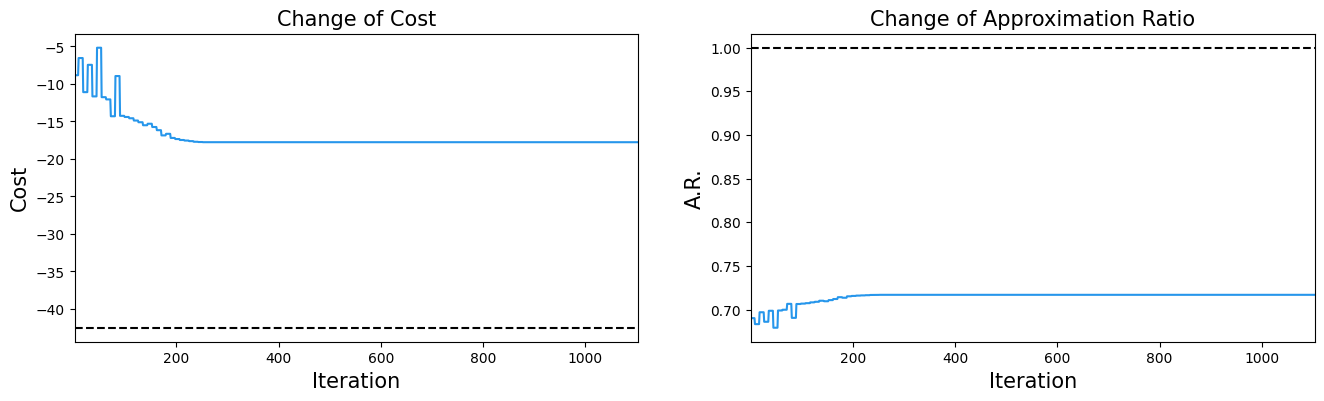

In [89]:
fig1, ax1 = plt.subplots(1, 2, figsize=(16,4))

ax1[0].plot(cost_history, label="Cost", color="#2696EB")
ax1[0].axhline(exact_val, linestyle="--", color="black")
ax1[0].set_xlim(1, result.nfev)
ax1[0].set_xlabel("Iteration", fontsize=15)
ax1[0].set_ylabel("Cost", fontsize=15)
ax1[0].set_title("Change of Cost", fontsize=15)

ax1[1].plot(1.0 - np.abs(np.array(cost_history)-min_energy) / energy_range, label="AR", color="#2696EB")
ax1[1].axhline(1.0, linestyle="--", color="black")
ax1[1].set_xlim(1, result.nfev)
ax1[1].set_xlabel("Iteration", fontsize=15)
ax1[1].set_ylabel("A.R.", fontsize=15)
ax1[1].set_title("Change of Approximation Ratio", fontsize=15)

plt.show()

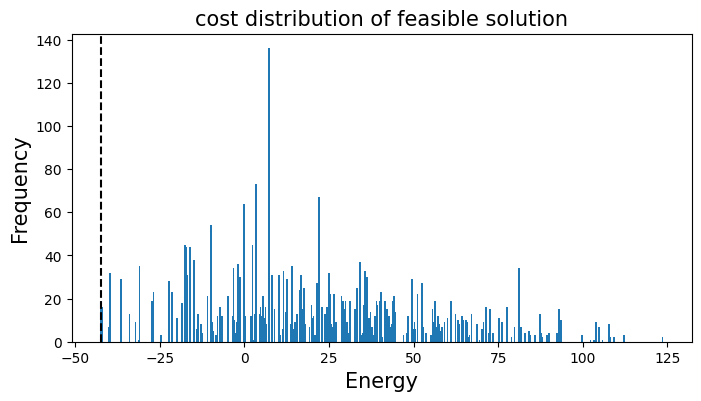

In [90]:
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

sampleset = fqaoa_converter.decode(qk_transpiler, job_result.data["meas"])
plot_data = {}
energies = []
frequencies = []
for entry in sampleset.raw.objectives.entries:
    energies.append(entry.value)
    frequencies.append(len(entry.ids))

fig2, ax2 = plt.subplots(figsize=(8,4))
ax2.bar(energies, frequencies, width=0.5)
ax2.axvline(exact_val, linestyle="--", color="black")
ax2.set_title("cost distribution of feasible solution", fontsize=15)
ax2.set_ylabel("Frequency", fontsize=15)
ax2.set_xlabel("Energy", fontsize=15)

plt.show()

In [91]:
print("feasible solutions: ",(df_sampleset['feasible'] == True).sum())
print("infeasible solutions: ",(df_sampleset['feasible'] == False).sum())

feasible solutions:  10000
infeasible solutions:  0
